# first import the needed libraries
___

In [111]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from scipy import signal
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

import the data

In [99]:
data_directory = './data/mars/training/data/'
mseed_file = f'{data_directory}XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed'
st = read(mseed_file)
st

1 Trace(s) in Stream:
XB.ELYSE.02.BHV | 2022-01-02T04:00:00.025000Z - 2022-01-02T04:59:59.975000Z | 20.0 Hz, 72000 samples

play with the data and get some insights

In [100]:
st[0].stats
trace = st.traces[0].copy()
time_data = trace.times()
vel_data  = trace.data

Text(0.5, 1.0, 'xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed')

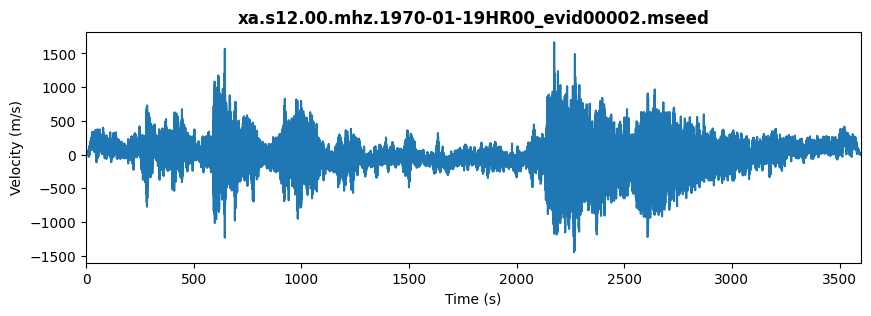

In [101]:
# Initialize figure
fig, graph = plt.subplots(1,1,figsize=(10,3))

# Plot trace
graph.plot(time_data,vel_data)


# Make the plot pretty
graph.set_xlim([min(time_data),max(time_data)])
graph.set_ylabel('Velocity (m/s)')
graph.set_xlabel('Time (s)')
graph.set_title(f'xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed', fontweight='bold')

filter the data

In [102]:
# Set the minimum frequency
minfreq = .5
maxfreq = 1

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
time_data_fil = tr_filt.times()
vel_data_fil = tr_filt.data

plot the filtered data

Text(0.5, 1.0, 'xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed')

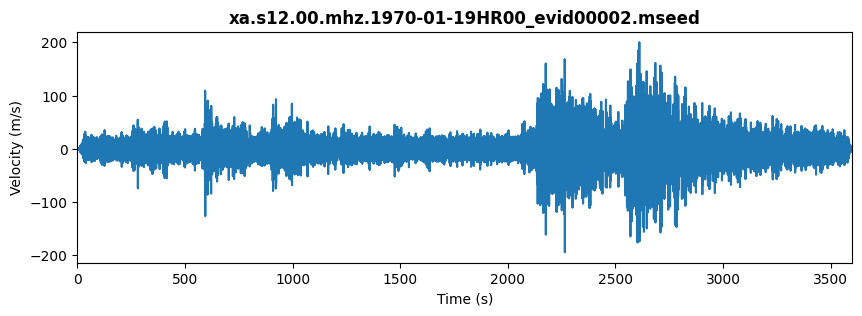

In [103]:
# Initialize figure
fig, graph = plt.subplots(1,1,figsize=(10,3))

# Plot trace
graph.plot(time_data_fil,vel_data_fil)


# Make the plot pretty
graph.set_xlim([min(time_data_fil),max(time_data_fil)])
graph.set_ylabel('Velocity (m/s)')
graph.set_xlabel('Time (s)') 
graph.set_title(f'xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed', fontweight='bold')

applying STA/LTA algorithm to detect the arrival time of the seismic wave

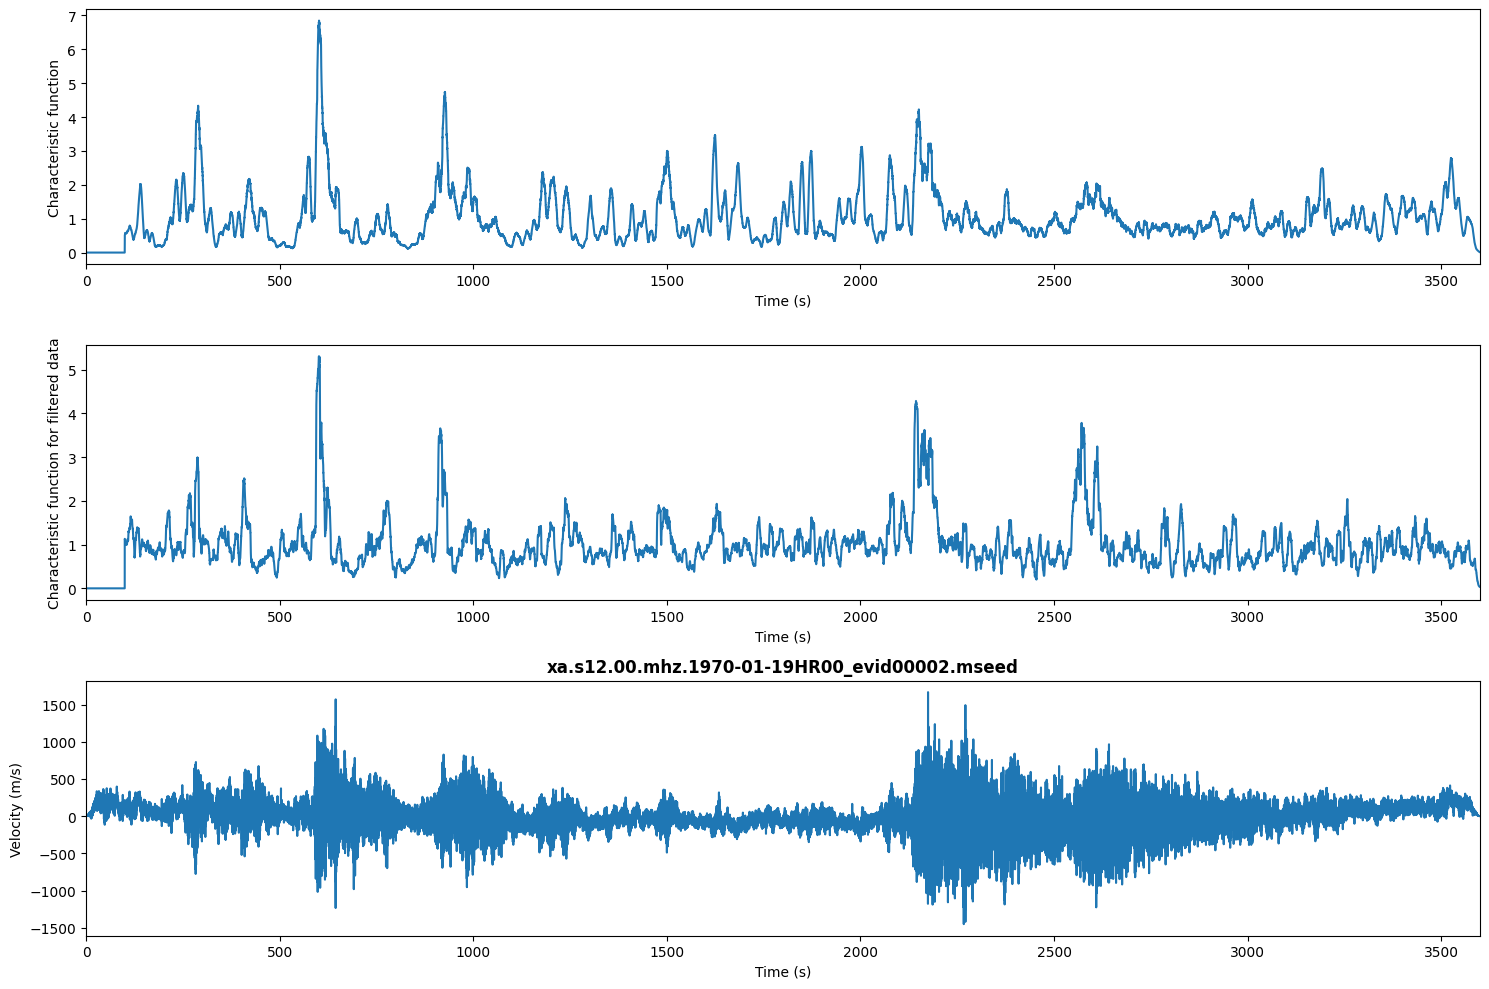

In [110]:
# Sampling frequency of our trace
SF = trace.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 10
lta_len = 100

# Run Obspy's STA/LTA to obtain a characteristic function
# This function basically calculates the ratio of amplitude between the short-term 
# and long-term windows, moving consecutively in time across the data
cft = classic_sta_lta(vel_data, int(sta_len * SF), int(lta_len * SF))
cft_filtered = classic_sta_lta(vel_data_fil, int(sta_len * SF), int(lta_len * SF))

# Plot characteristic function

#for unfiltered
import matplotlib.pyplot as plt

# Create the figure and axes
fig = plt.figure(figsize=(15, 10))

# First subplot
ax = plt.subplot(3, 1, 1)  # (nrows, ncols, index)
ax.plot(time_data, cft)
ax.set_xlim([min(time_data), max(time_data)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')

# Second subplot
ax2 = plt.subplot(3, 1, 2)  # Second subplot
ax2.plot(time_data_fil, cft_filtered)
ax2.set_xlim([min(time_data_fil), max(time_data_fil)])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Characteristic function for filtered data')

# Third subplot
graph = plt.subplot(3, 1, 3)  # Third subplot
graph.plot(time_data, vel_data)
graph.set_xlim([min(time_data_fil), max(time_data_fil)])
graph.set_xlabel('Time (s)')
graph.set_ylabel('Velocity (m/s)')
graph.set_title('xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed', fontweight='bold')

# Display the plot
plt.tight_layout()
plt.show()


so what we want is to play around with the values of STA_len & LTA_len so we get the cft overshoot at the seismic event which in this case at the second 75000 from the start of the seismic stream...

>then we want to set a treshold value to identify the arrival time of each seismic event.